In [1]:
import sys
import os
import SSGATE as ssgate
import scanpy as sc

import torch
import matplotlib.pyplot as plt

os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
# This tutorial is used to illustrate the steps of multi-omics integration of the BMNC dataset.
# Import transcriptome and proteome data in h5ad format
# adata_st = sc.read_h5ad('BMNC_RNA.h5ad')
# adata_sp = sc.read_h5ad('BMNC_ADT.h5ad')

adata_st = sc.read_h5ad('../data/BMNC/Raw/BMNC_RNA.h5ad')
adata_sp = sc.read_h5ad('../data/BMNC/Raw/BMNC_ADT.h5ad')

In [3]:
adata_st

AnnData object with n_obs × n_vars = 30672 × 17009
    obs: 'celltype_l1', 'celltype_l2'

In [4]:
adata_sp

AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'celltype_l1', 'celltype_l2'
    obsm: 'normalized_counts'

Original ST Data Info: 30672 cells * 17009 genes.


/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Original SP Data Info: 30672 cells * 25 genes.


/opt/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


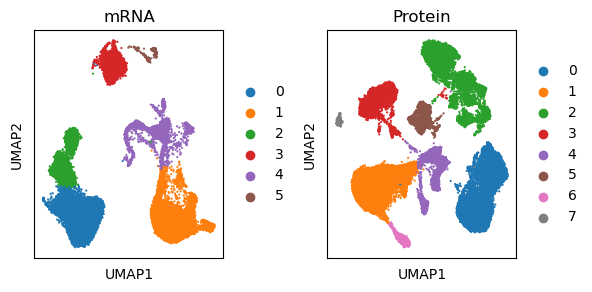

In [3]:
# The above data is not filtered or standardized by default, 
# and is preprocessed using the preprocessing function of SSGATE.
adata_st, adata_sp = ssgate.preprocess_cluster(adata_st, adata_sp, res_st = 0.1, res_sp = 0.05, show_fig = True, figsize = (6,3))

In [ ]:
# Neighbor network construction, 
# network pruning, 
# and neighbor network statistics based on transcriptome data
adata_st = ssgate.Cal_Nbrs_Net(adata_st, feat = "X_pca", k_cutoff = 15, model = "KNN")
adata_st = ssgate.prune_net(adata_st)
ssgate.Stats_Nbrs_Net(adata_st)

------Calculating spatial graph...


In [ ]:
# Proteomic data are processed similarly to transcriptomic data
adata_sp = ssgate.Cal_Nbrs_Net(adata_sp, feat = "X_pca", k_cutoff = 15, model = "KNN")
adata_sp = ssgate.prune_net(adata_sp)
ssgate.Stats_Nbrs_Net(adata_sp)

In [ ]:
# After the nearest neighbor network is built, it is trained based on the above data, 
# and the integrated results obtained from the training are retained in the .obsm file of h5ad.
adata_st, adata_sp = ssgate.train(adata_st, adata_sp, 
                                    hidden_dims1 = 128, 
                                    hidden_dims2 = 128, 
                                    out_dims = 30, 
                                    cluster_update_epoch = 50, 
                                    epochs_init = 50, 
                                    n_epochs=300, 
                                    save_reconstrction=False, 
                                    sigma = 0.1, 
                                    device = "cuda:0", 
                                    feat1 = "PCA",
                                    key_added = 'ssgate_embed')

In [ ]:
# Calculate neighbors and construct UMAP graph based on integrated low-dimensional embedding
sc.pp.neighbors(adata_st, use_rep="ssgate_embed",key_added='SSGATE_neighbor')
sc.tl.umap(adata_st,neighbors_key='SSGATE_neighbor')

In [ ]:
# Leiden cluster statistics and drawing UMAP graph
sc.tl.leiden(adata_st, resolution = 0.15, key_added = "ssgate_cluster")
plt.rcParams["figure.figsize"] = [3,3]
sc.pl.umap(adata_st, color=["ssgate_cluster"], title = "SSGATE clusters")